# Cyberbullying On Social Media

# XGBoost with GridSearchCV

**NOTE: Please note that running the entire notebook takes approximately 20 hours.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
# !pip install xgboost

import xgboost as xgb

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# !pip install tabletext
import tabletext

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
comments = df['tidy_text']
labels = df['label_bullying']

In [4]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

***

**Utility Functions**

***

In [5]:
def custom_f1_score(predictions, d_train):
    labels = d_train.get_label().astype(np.int)
    predictions = (predictions >= 0.5).astype(np.int)
    return [('f1_score', f1_score(labels, predictions))]

In [6]:
# setup color scheme and standard figure size for all figures
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [8]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**XGBoost**

***

Extreme Gradient Boosting (xgboost) is an advanced implementation of the gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. 

Some key benefits of XGBoost are:

- Regularization - helps in reducing overfitting

- Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

- Handling Missing Values - It has an in-built routine to handle missing values.

- Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process

**Hyperparameter Tuning**

In order to tune the hyperparameters, I will use a grid search with 5-fold cross-validation. It allows  to run cross-validation on the training dataset and returns a score (either built-in or customly defined).

**A note about using XGBoost with GridSearchCV**

I wanted to compare the results obtaining by tuning XGBoost manually versus using GridSearchCV. As mentioned in the other notebook, using GridSearchCV for so many parameters is computationally very expensive. So I decided to slightly reduce the search space here. Overall running the entire notebook requires about 20-30 hours (depending on the run). For this reason I only did it once, just to compare. Interestingly GridSearchCV found at time completely different best parameters than my manual search (at times with quite big difference in terms of max_depth and min_child_weight for example). However, the end results are almost the same. This implies that tuning the hyperparameters plays a secondary role, and the results cannot be improved much, because of the nature of the data set (small data set and non-separable classes).

**Tune max_depth and min_child_weight** 

- max_depth is the largest depth allowed on any decision tree in the ensemble, where tree depth is the number of nodes from the root down to the farthest away leaf. Larger max_depth values allow for more complex trees, which means a larger chance of capturing complicated features but also a larger chance of overfitting.
- min_child_weight is a regularization factor that changes how often tree nodes split in tree creation. 

**Tune subsample and colsample**

- subsample is the fraction of datapoints (rows of the training data) to sample at each round (each tree), with 0 meaning no rows are sampled and 1 meaning all rows are sampled. The higher the value, the more likely to overfit the data.
- colsample_bytree is the fraction of features (columns of the training data) to sample at each round (each tree), with 0 meaning no columns are sampled and 1 meaning all columns are sampled. The higher the value, the more likely to overfit the data.

**Tune eta**

Eta in XGBoost works the same way as a learning_rate, in the sense that it controls how quickly each step changes. The smaller the eta, the smaller each step, which means the algorithm will likely take more steps to converge.

**Tune num_boost_round and early_stopping_rounds**

XGBoost is a gradient boosting method, as such it adds trees in every iteration to improve the prediction accuracy (performance). 

The prediction performance increases when you add more and more trees until it starts to overfit, at which point the it will start to decrease. So we need to find that optimum number of trees. It is basically impossible to guess this number from the get-go. That is what XGBoost.cv is for. It partitions the training data into two subsets. The first subset is used to train XGBoost, the second is used as a validation set. After each iteration (which adds an additional tree) XGBoost calculates the new validation error. With that XGBoost is able to detect when it starts to overfit (when the validation error starts to increase). This will give us the optimal number of trees for a given set of hyperparameters.

The num_boost_rounds (number of trees) parameter is not part of the PARAMETERS dictionary, but it is a tunable parameter. num_boost_round corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time we update a parameter. I could do this by tuning it together with all parameters in a grid-search, but it requires a lot of computational effort.
Fortunately XGBoost provides a nice way to find the best number of rounds while training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/boost round improves performance. If the performance hasn’t improved for a specific number of rounds (as defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds. 

- num_boost_round: number of boosting rounds. Here I will use a large number and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
- metrics: the metrics to use to evaluate the model. For this part I have defined a custom F1 score metric, since XGBoost does not have one natively, and I wanted to compare to other classifiers using the same metric.


I've decided here to use the XGBoost algorithm directly but there is also a scikit learn wrapper around XGBoost called XGBRegressor. The XGBoost algorithm is more customizeable, but the scikit learn wrapper plays more nicely with pipelines (and doesn't need DMatrix input).

In [9]:
# Initialize with default parameters
PARAMETERS = {
     'objective':'binary:logistic',
     'max_depth': 6,
     'min_child_weight': 1,
     'eta': .3,
     'subsample': 1,
     'colsample_bytree': 1
  }

***

**TF-IDF**

***

In [10]:
train_tfidf_features = np.load('train_dataset_unbalanced_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_unbalanced_tfidf_labels.npy', allow_pickle=True)

In [11]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [12]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [13]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf .shape, x_train_tfidf .dtype)
print('y:', y_train_tfidf .shape, y_train_tfidf .dtype)

x: (7943, 1000) float64
y: (7943,) int64


In [14]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (1104, 1000) float64
y: (1104,) int64


In [15]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (1986, 1000) float64
y: (1986,) int64


Let's define the search space for grid search. I have tried wider intervals with a larger step between each value and then narrowed it down. After several iterations I found that the optimal value was in the following ranges. Here I am showing only the final selection of parameters since this is computationally very expensive.

In [16]:
SEARCH_SPACE = [
  {
    'classifier__max_depth': range(3,10,2),
    'classifier__min_child_weight': range(1,6,2),
    'classifier__colsample_bytree': [0.8, 0.9, 1],
    'classifier__subsample': [0.8, 0.9, 1],
    'classifier__eta': [.3, .2, .1],
  }
]

In [17]:
pipeline = Pipeline(steps = [('sm', SMOTE(random_state = RANDOM_STATE)), ('classifier', xgb.XGBClassifier(objective = 'binary:logistic'))])

In [18]:
SCORING = {'AUC': 'roc_auc', 'F1': 'f1'}

In [19]:
gs = GridSearchCV(pipeline, SEARCH_SPACE, cv = 5, scoring=SCORING, refit = 'F1', return_train_score = True, verbose = True, n_jobs=-1)

In [20]:
gs.fit(x_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 87.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 114.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=12)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                         

Let’s have a look at the final list of tuned parameters.

In [21]:
print(gs.best_params_) 
print(gs.best_score_) 
print(gs.best_estimator_) 

{'classifier__colsample_bytree': 0.8, 'classifier__eta': 0.2, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__subsample': 0.8}
0.46799632651043205
Pipeline(steps=[('sm', SMOTE(random_state=12)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eta=0.2, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                            

In [22]:
PARAMETERS['max_depth'] = gs.best_params_['classifier__max_depth']
PARAMETERS['min_child_weight'] = gs.best_params_['classifier__min_child_weight']
PARAMETERS['subsample'] = gs.best_params_['classifier__subsample']
PARAMETERS['colsample_bytree'] = gs.best_params_['classifier__colsample_bytree']
PARAMETERS['eta'] = gs.best_params_['classifier__eta']

In [23]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 3,
 'min_child_weight': 1,
 'eta': 0.2,
 'subsample': 0.8,
 'colsample_bytree': 0.8}

**DMatrices**

Instead of numpy arrays or pandas data frames, XGBoost uses DMatrices. A DMatrix can contain both the features and the target. The data is already loaded into arrays, so I can use them to create the DMatrix. 

In [24]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_tfidf_sm, y_train_tfidf_sm = sm.fit_sample(x_train_tfidf, y_train_tfidf)

In [25]:
# A DMatrix can contain both the features and the target.
d_train_tfidf = xgb.DMatrix(x_train_tfidf_sm, label = y_train_tfidf_sm) 
d_test_tfidf = xgb.DMatrix(x_test_tfidf, label = y_test_tfidf) 
d_val_tfidf = xgb.DMatrix(x_val_tfidf, label = y_val_tfidf)
watchlist_tfidf = [(d_train_tfidf, 'train'), (d_val_tfidf, 'val')]

In [26]:
NUM_BOOST_ROUNDS = 1000
EARLY_STOPPING_ROUNDS = 20

Finally I can now use the parameters tuned in the previous steps in the xgboost model. I will set a very high num_boost_round and rely on early stopping to stop the model if its performance doesn’t improve in 20 rounds.

In [27]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_tfidf,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_tfidf,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.41499	val-error:0.26939	train-f1_score:0.33319	val-f1_score:0.24965
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.36757	val-error:0.32377	train-f1_score:0.53797	val-f1_score:0.39167
[2]	train-error:0.36695	val-error:0.31974	train-f1_score:0.53571	val-f1_score:0.39466
[3]	train-error:0.35819	val-error:0.30765	train-f1_score:0.54775	val-f1_score:0.40622
[4]	train-error:0.35810	val-error:0.31118	train-f1_score:0.54942	val-f1_score:0.40116
[5]	train-error:0.35757	val-error:0.31470	train-f1_score:0.55069	val-f1_score:0.40191
[6]	train-error:0.34156	val-error:0.31722	train-f1_score:0.58219	val-f1_score:0.40678
[7]	train-error:0.33554	val-error:0.31521	train-f1_score:0.59385	val-f1_score:0.40943
[8]	train-error:0.33156	val-error:0.31370	train-f1_score:0.59820	val-f1_score:0.41060
[9]	train-error:0.32413	val-error:0.31672	train-f1_score:0.61013	val-f1_score

In [28]:
# XGBoost returns probabilities by default.
y_probas_train_tfidf = xgb_model.predict(d_train_tfidf)
y_probas_test_tfidf = xgb_model.predict(d_test_tfidf)

In [29]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf)

In [30]:
cnf_matrix = metrics.confusion_matrix(y_test_tfidf, y_pred_test_tfidf)
cnf_matrix

array([[588, 197],
       [158, 161]])

True Negatives:  588
False Positives:  197
False Negatives:  158
True Positives:  161


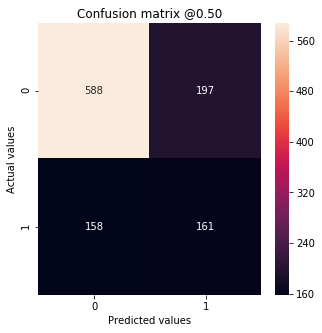

In [31]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [32]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       785
           1       0.45      0.50      0.48       319

    accuracy                           0.68      1104
   macro avg       0.62      0.63      0.62      1104
weighted avg       0.69      0.68      0.68      1104



GridSearchCV find different parameters than my manual tuning of the hyperparameters. Although the end results aren't any different, this configuration of the model achieves better precision and recall for the minority class with 161 samples predicted correctly.

In [33]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('TFDIF F1: %.3f' % f1_tfidf)

TFDIF F1: 0.684


In [34]:
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('TFIDF AUC: %.3f' % auc_tfidf)

TFIDF AUC: 0.683


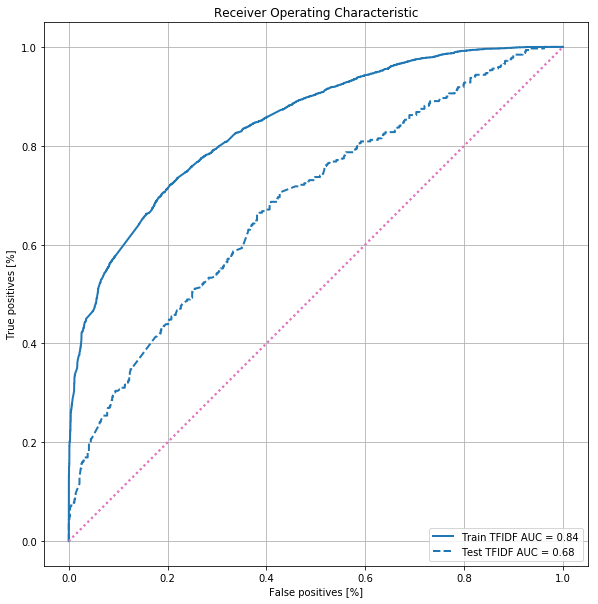

In [35]:
plot_roc("Train TFIDF", y_train_tfidf_sm, y_probas_train_tfidf, color = colors[0])
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***

**Word2Vec**

***

In [36]:
w2v_features = np.load('w2v_features.npy', allow_pickle=True)

In [37]:
# Create X/y arrays
comments_w2v = w2v_features
labels_w2v = labels
print('x:', comments_w2v.shape, comments_w2v.dtype) 
print('y:', labels_w2v.shape, labels_w2v.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [38]:
x_train_val_w2v, x_test_w2v, y_train_val_w2v, y_test_w2v = train_test_split(comments_w2v, labels_w2v,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_w2v,
                                                  random_state = RANDOM_STATE)

In [39]:
x_train_w2v, x_val_w2v, y_train_w2v, y_val_w2v = train_test_split(x_train_val_w2v, y_train_val_w2v,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_w2v,
                                                  random_state = RANDOM_STATE)

In [40]:
gs = GridSearchCV(pipeline, SEARCH_SPACE, cv = 5, scoring = SCORING, refit = 'F1', return_train_score = True, verbose = True, n_jobs = -1)

In [41]:
gs.fit(x_train_w2v, y_train_w2v)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 143.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=12)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                         

In [42]:
print(gs.best_params_) 
print(gs.best_score_) 
print(gs.best_estimator_) 

{'classifier__colsample_bytree': 0.8, 'classifier__eta': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__subsample': 0.9}
0.48372357829674417
Pipeline(steps=[('sm', SMOTE(random_state=12)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eta=0.1, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=3, min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                            

In [43]:
PARAMETERS['max_depth'] = gs.best_params_['classifier__max_depth']
PARAMETERS['min_child_weight'] = gs.best_params_['classifier__min_child_weight']
PARAMETERS['subsample'] = gs.best_params_['classifier__subsample']
PARAMETERS['colsample_bytree'] = gs.best_params_['classifier__colsample_bytree']
PARAMETERS['eta'] = gs.best_params_['classifier__eta']

In [44]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_w2v_sm, y_train_w2v_sm = sm.fit_sample(x_train_w2v, y_train_w2v)

In [45]:
# A DMatrix can contain both the features and the target.
d_train_w2v = xgb.DMatrix(x_train_w2v_sm, label = y_train_w2v_sm) 
d_val_w2v = xgb.DMatrix(x_val_w2v, label = y_val_w2v)
d_test_w2v = xgb.DMatrix(x_test_w2v, label = y_test_w2v)
watchlist_w2v = [(d_train_w2v, 'train'), (d_val_w2v, 'val')]

In [46]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_w2v,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_w2v,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.37376	val-error:0.35448	train-f1_score:0.60833	val-f1_score:0.47852
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.34191	val-error:0.33736	train-f1_score:0.63389	val-f1_score:0.48933
[2]	train-error:0.34581	val-error:0.34038	train-f1_score:0.62740	val-f1_score:0.48080
[3]	train-error:0.33183	val-error:0.32326	train-f1_score:0.64482	val-f1_score:0.50233
[4]	train-error:0.32944	val-error:0.32880	train-f1_score:0.64954	val-f1_score:0.50191
[5]	train-error:0.32758	val-error:0.33182	train-f1_score:0.65589	val-f1_score:0.50488
[6]	train-error:0.32351	val-error:0.33484	train-f1_score:0.66261	val-f1_score:0.50113
[7]	train-error:0.32086	val-error:0.33837	train-f1_score:0.66661	val-f1_score:0.49926
[8]	train-error:0.32086	val-error:0.32981	train-f1_score:0.66593	val-f1_score:0.50863
[9]	train-error:0.32077	val-error:0.33384	train-f1_score:0.66581	val-f1_score

In [47]:
y_probas_train_w2v = xgb_model.predict(d_train_w2v)
y_probas_test_w2v = xgb_model.predict(d_test_w2v)

In [48]:
y_pred_test_w2v = np.round(y_probas_test_w2v)

In [49]:
cnf_matrix = metrics.confusion_matrix(y_test_w2v, y_pred_test_w2v)
cnf_matrix

array([[563, 222],
       [159, 160]])

True Negatives:  563
False Positives:  222
False Negatives:  159
True Positives:  160


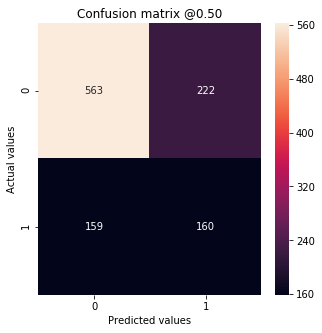

In [50]:
plot_cfm(y_test_w2v, y_pred_test_w2v)

In [51]:
print(classification_report(y_test_w2v, y_pred_test_w2v))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       785
           1       0.42      0.50      0.46       319

    accuracy                           0.65      1104
   macro avg       0.60      0.61      0.60      1104
weighted avg       0.68      0.65      0.66      1104



In [52]:
f1_w2v = f1_score(y_test_w2v, y_pred_test_w2v, average = 'weighted')
print('W2V F1: %.3f' % f1_w2v)

W2V F1: 0.663


In [53]:
auc_w2v = roc_auc_score(y_test_w2v, y_probas_test_w2v)
print('W2V AUC: %.3f' % auc_w2v)

W2V AUC: 0.685


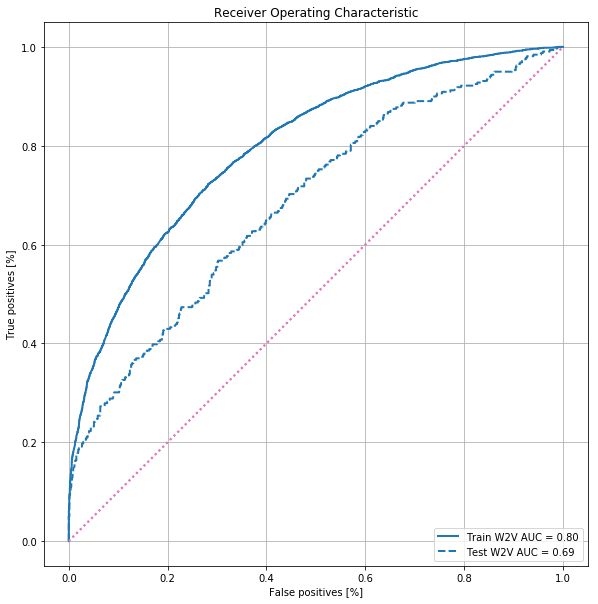

In [54]:
plot_roc("Train W2V", y_train_w2v_sm, y_probas_train_w2v, color = colors[0])
plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[0], linestyle='--')

***

**Glove/FastText Embeddings**

***

In [55]:
gft_features = np.load('gloveft_features.npy', allow_pickle=True)

In [56]:
# Create X/y arrays
comments_gft = gft_features
labels_gft = labels
print('x:', comments_gft.shape, comments_gft.dtype) 
print('y:', labels_gft.shape, labels_gft.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [57]:
x_train_val_gft, x_test_gft, y_train_val_gft, y_test_gft = train_test_split(comments_gft, labels_gft,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_gft,
                                                  random_state = RANDOM_STATE)

In [58]:
x_train_gft, x_val_gft, y_train_gft, y_val_gft = train_test_split(x_train_val_gft, y_train_val_gft,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_gft,
                                                  random_state = RANDOM_STATE)

In [59]:
gs = GridSearchCV(pipeline, SEARCH_SPACE, cv = 5, scoring = SCORING, refit = 'F1', return_train_score = True, verbose = True, n_jobs = -1)

In [60]:
gs.fit(x_train_gft, y_train_gft)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 298.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 372.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 412.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=12)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                         

In [61]:
print(gs.best_params_) 
print(gs.best_score_) 
print(gs.best_estimator_) 

{'classifier__colsample_bytree': 0.8, 'classifier__eta': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__subsample': 1}
0.48379636547364485
Pipeline(steps=[('sm', SMOTE(random_state=12)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eta=0.1, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              

In [62]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_gft_sm, y_train_gft_sm = sm.fit_sample(x_train_gft, y_train_gft)

In [63]:
PARAMETERS['max_depth'] = gs.best_params_['classifier__max_depth']
PARAMETERS['min_child_weight'] = gs.best_params_['classifier__min_child_weight']
PARAMETERS['subsample'] = gs.best_params_['classifier__subsample']
PARAMETERS['colsample_bytree'] = gs.best_params_['classifier__colsample_bytree']
PARAMETERS['eta'] = gs.best_params_['classifier__eta']

In [64]:
# A DMatrix can contain both the features and the target.
d_train_gft = xgb.DMatrix(x_train_gft_sm, label = y_train_gft_sm) 
d_val_gft = xgb.DMatrix(x_val_gft, label = y_val_gft)
d_test_gft = xgb.DMatrix(x_test_gft, label = y_test_gft)
watchlist_gft = [(d_train_gft, 'train'), (d_val_gft, 'val')]

In [65]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_gft,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_gft,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.36403	val-error:0.35096	train-f1_score:0.59700	val-f1_score:0.44106
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.36226	val-error:0.34945	train-f1_score:0.59967	val-f1_score:0.44480
[2]	train-error:0.34475	val-error:0.36304	train-f1_score:0.63993	val-f1_score:0.44751
[3]	train-error:0.33740	val-error:0.34894	train-f1_score:0.63855	val-f1_score:0.44956
[4]	train-error:0.33457	val-error:0.34542	train-f1_score:0.64667	val-f1_score:0.46490
[5]	train-error:0.32803	val-error:0.34038	train-f1_score:0.65313	val-f1_score:0.47270
[6]	train-error:0.31918	val-error:0.33887	train-f1_score:0.66362	val-f1_score:0.46882
[7]	train-error:0.31679	val-error:0.34340	train-f1_score:0.66417	val-f1_score:0.46468
[8]	train-error:0.31670	val-error:0.34038	train-f1_score:0.66667	val-f1_score:0.46939
[9]	train-error:0.31299	val-error:0.33938	train-f1_score:0.66773	val-f1_score

In [66]:
y_probas_train_gft = xgb_model.predict(d_train_gft)
y_probas_test_gft = xgb_model.predict(d_test_gft)

In [67]:
y_pred_test_gft = np.round(y_probas_test_gft)

In [68]:
cnf_matrix = metrics.confusion_matrix(y_test_gft, y_pred_test_gft)
cnf_matrix

array([[575, 210],
       [157, 162]])

True Negatives:  575
False Positives:  210
False Negatives:  157
True Positives:  162


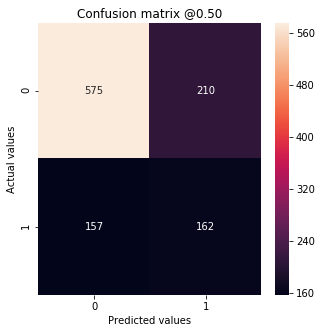

In [69]:
plot_cfm(y_test_gft, y_pred_test_gft)

In [70]:
print(classification_report(y_test_gft, y_pred_test_gft))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       785
           1       0.44      0.51      0.47       319

    accuracy                           0.67      1104
   macro avg       0.61      0.62      0.61      1104
weighted avg       0.68      0.67      0.67      1104



In [71]:
f1_gft = f1_score(y_test_gft, y_pred_test_gft, average='weighted')
print('Glove/FastText F1: %.3f' % f1_gft)

Glove/FastText F1: 0.675


In [72]:
auc_gft = roc_auc_score(y_test_gft, y_probas_test_gft)
print('Glove/FastText AUC: %.3f' % auc_gft)

Glove/FastText AUC: 0.674


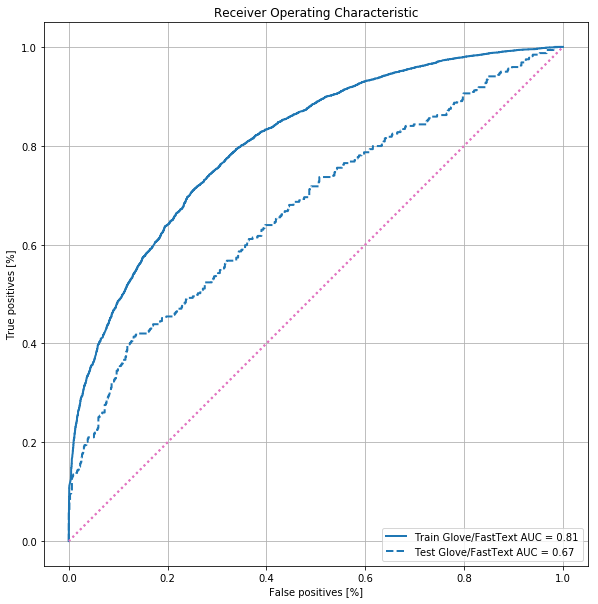

In [73]:
plot_roc("Train Glove/FastText", y_train_gft_sm, y_probas_train_gft, color = colors[0])
plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[0], linestyle = '--')

***

**Summary**

***

In [74]:
data = [["Classifier", "F1", "AUC"],
        ["XGBoost w. TFIDF", f1_tfidf, auc_tfidf],
        ["XGBoost w. Word2Vec", f1_w2v, auc_w2v],
        ["XGBoost w. Glove/FastText", f1_gft, auc_gft],
        ]

print (tabletext.to_text(data))

┌───────────────────────────┬────────────────────┬────────────────────┐
│ Classifier                │ F1                 │ AUC                │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. TFIDF          │  0.683608427494417 │ 0.6831839147015953 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Word2Vec       │ 0.6631854226884968 │ 0.6854102190363995 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Glove/FastText │ 0.6745140589652208 │ 0.6743645548389673 │
└───────────────────────────┴────────────────────┴────────────────────┘


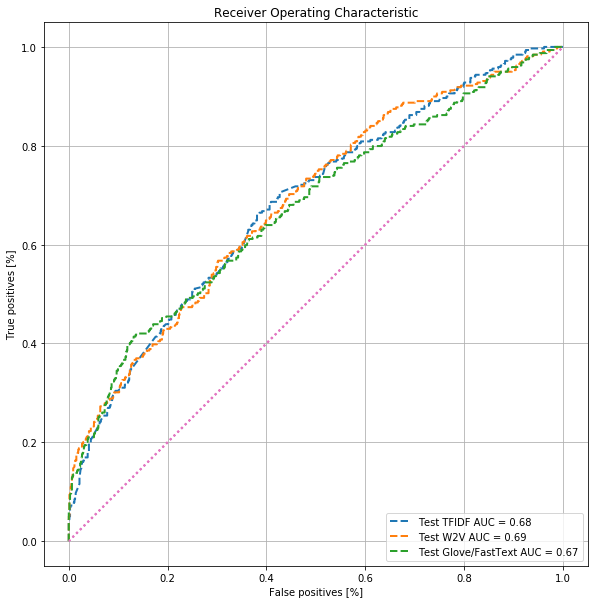

In [75]:
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[1], linestyle = '--')

plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[2], linestyle = '--')